In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import FancyArrowPatch, Polygon

from hydro_forecasting.data.caravanify_parquet import CaravanifyParquet, CaravanifyParquetConfig

In [2]:
config = CaravanifyParquetConfig(
    attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
    shapefile_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/shapefiles",
    gauge_id_prefix="CA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

caravan = CaravanifyParquet(config)

basin_ids = caravan.get_all_gauge_ids()

caravan.load_stations(basin_ids)

gdf = caravan.get_shapefiles()

In [3]:
def load_basin_ids(country: str) -> list[str]:
    """
    Function to load basins for a given country in Central Asia
    """
    # Make country lowercase and make the first letter uppercase
    country = country.lower()
    country = country.capitalize()

    if country != "Tajikistan" and country != "Kyrgyzstan":
        print("Country not supported")
        return []

    configs = CaravanifyParquetConfig(
        attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
        timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
        gauge_id_prefix="CA",
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )

    caravan = CaravanifyParquet(configs)
    ca_basins = caravan.get_all_gauge_ids()
    caravan.load_stations(ca_basins)
    static_data = caravan.get_static_attributes()

    return list(static_data[static_data["country"] == country]["gauge_id"].unique())


tajik_basins = load_basin_ids("Tajikistan")
kyrgyz_basins = load_basin_ids("Kyrgyzstan")

In [4]:
# Create mapping dictionary
country_mapping = {
    **dict.fromkeys(tajik_basins, "Tajikistan"),
    **dict.fromkeys(kyrgyz_basins, "Kyrgyzstan"),
}

# Add country column
gdf["country"] = gdf["gauge_id"].map(country_mapping).fillna("Unknown")

# Drop basins not in Tajikistan or Kyrgyzstan
gdf = gdf[gdf["country"].isin(["Tajikistan", "Kyrgyzstan"])]

In [5]:
gdf

,gauge_id,geometry,country
0,CA_15013,"POLYGON ((78.98551 42.67817, 78.98792 42.67796...",Kyrgyzstan
1,CA_15016,"POLYGON ((78.92975 42.59671, 78.93336 42.59639...",Kyrgyzstan
2,CA_15020,"POLYGON ((78.52708 42.47201, 78.53308 42.47151...",Kyrgyzstan
3,CA_15022,"POLYGON ((78.6156 42.47085, 78.6168 42.47074, ...",Kyrgyzstan
4,CA_15025,"POLYGON ((78.4813 42.45065, 78.4825 42.45055, ...",Kyrgyzstan
...,...,...,...
74,CA_17325,"POLYGON ((68.29214 39.32245, 68.29562 39.32247...",Tajikistan
75,CA_17329,"POLYGON ((69.64797 39.28405, 69.65029 39.28404...",Tajikistan
76,CA_17338,"POLYGON ((68.29214 39.32245, 68.29562 39.32247...",Tajikistan
77,CA_17344,"POLYGON ((67.71367 39.48959, 67.71948 39.48966...",Tajikistan


In [6]:
path_to_cluster = (
    "/Users/cooper/Desktop/hydro-forecasting/scripts/cluster_basins/classification_results/cluster_probabilities.csv"
)

df = pd.read_csv(path_to_cluster)

df = df[df["gauge_id"].isin(gdf["gauge_id"])][["gauge_id", "predicted_cluster"]]

gdf = gdf.merge(df, on="gauge_id", how="left")

gdf

,gauge_id,geometry,country,predicted_cluster
0,CA_15013,"POLYGON ((78.98551 42.67817, 78.98792 42.67796...",Kyrgyzstan,7
1,CA_15016,"POLYGON ((78.92975 42.59671, 78.93336 42.59639...",Kyrgyzstan,7
2,CA_15020,"POLYGON ((78.52708 42.47201, 78.53308 42.47151...",Kyrgyzstan,7
3,CA_15022,"POLYGON ((78.6156 42.47085, 78.6168 42.47074, ...",Kyrgyzstan,7
4,CA_15025,"POLYGON ((78.4813 42.45065, 78.4825 42.45055, ...",Kyrgyzstan,7
...,...,...,...,...
73,CA_17325,"POLYGON ((68.29214 39.32245, 68.29562 39.32247...",Tajikistan,7
74,CA_17329,"POLYGON ((69.64797 39.28405, 69.65029 39.28404...",Tajikistan,7
75,CA_17338,"POLYGON ((68.29214 39.32245, 68.29562 39.32247...",Tajikistan,7
76,CA_17344,"POLYGON ((67.71367 39.48959, 67.71948 39.48966...",Tajikistan,7


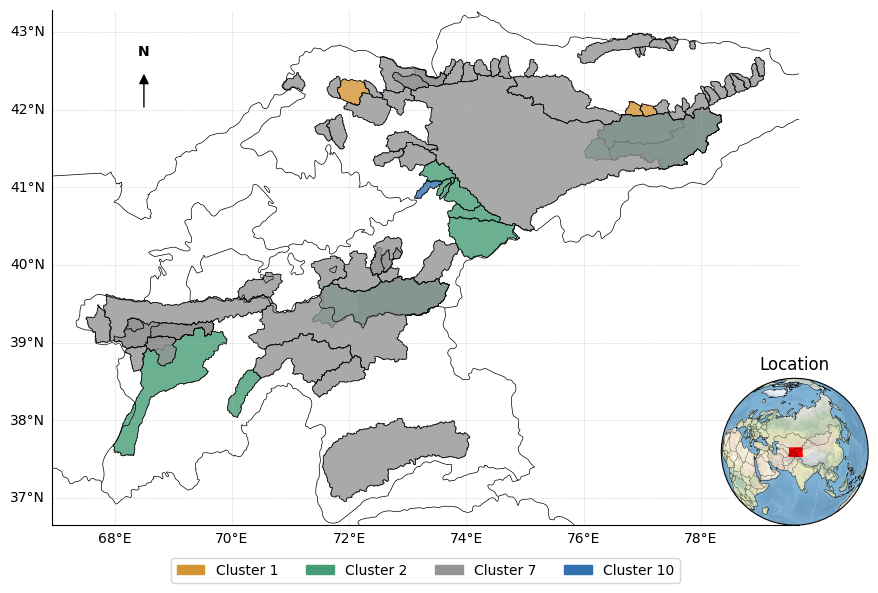

In [9]:
cluster_colors = {
    1: "#D39333",
    2: "#469C76",
    7: "#949494",
    10: "#3171AD",
}

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, alpha=0.0)
ax.add_feature(cfeature.OCEAN, alpha=0.0)
ax.add_feature(cfeature.LAKES, alpha=0.0)

# Plot CA basins with cluster-based coloring
for cluster, color in cluster_colors.items():
    cluster_basins = gdf[gdf["predicted_cluster"] == cluster]
    if not cluster_basins.empty:
        cluster_basins.plot(
            ax=ax,
            color=color,
            edgecolor="black",
            alpha=0.8,
            linewidth=0.5,
        )


# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

for spine in ax.spines.values():
    spine.set_visible(False)

# Set specific spines to be visible for axes
ax.spines["left"].set_visible(True)  # y-axis
ax.spines["bottom"].set_visible(True)  # x-axis

arrow_x, arrow_y = 68.5, 42  # Position it in the top right
arrow_length = 0.5

# Create the arrow
north_arrow = FancyArrowPatch(
    (arrow_x, arrow_y),
    (arrow_x, arrow_y + arrow_length),
    transform=ccrs.PlateCarree(),
    color="black",
    linewidth=1,
    arrowstyle="-|>",
    mutation_scale=15,
)
ax.add_patch(north_arrow)

# Add "N" label
ax.text(
    arrow_x,
    arrow_y + arrow_length + 0.2,
    "N",
    transform=ccrs.PlateCarree(),
    ha="center",
    fontsize=10,
    fontweight="bold",
)
ax_inset = fig.add_subplot(3, 4, 12, projection=ccrs.Orthographic(72, 40.5))

ax_inset.stock_img()

ax_inset.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax_inset.add_feature(cfeature.BORDERS, linewidth=0.2)

central_asia_extent = (67, 79, 37, 43)
min_lon, max_lon, min_lat, max_lat = central_asia_extent

poly_verts = np.array(
    [
        [min_lon, min_lat],
        [max_lon, min_lat],
        [max_lon, max_lat],
        [min_lon, max_lat],
        [min_lon, min_lat],
    ]
)

# Create and add the polygon
poly = Polygon(
    poly_verts,
    transform=ccrs.PlateCarree(),
    edgecolor="red",
    facecolor="red",
    alpha=1,
    linewidth=1.5,
)
ax_inset.add_patch(poly)

# Make the globe more complete by adjusting its appearance
ax_inset.set_global()  # Show the full globe

# Add a simple title to the inset map
ax_inset.set_title("Location", fontsize=12)

# Create custom legend handles for clusters that actually exist in the data
legend_handles = []
unique_clusters = sorted(gdf["predicted_cluster"].unique())
for cluster in unique_clusters:
    if cluster in cluster_colors:
        color = cluster_colors[cluster]
        handle = mpatches.Patch(color=color, alpha=1, label=f"Cluster {cluster}")
        legend_handles.append(handle)

# Add the legend with custom handles
ax.legend(
    handles=legend_handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(legend_handles), 6),
    frameon=True,
    fontsize=10,
)

plt.subplots_adjust(bottom=0.15, top=0.9, left=0.1, right=0.9)
plt.tight_layout()
plt.savefig(
    "/Users/cooper/Desktop/hydro-forecasting/images/maps/cluster_map_tajikistan_kyrgyzstan.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()